In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyabf
import os
import matplotlib.cm as cm
from scipy.signal import find_peaks

def detect_all_peaks(data_array, height_threshold=2, prominence_min=0.1, distance_min=5):

    peaks, properties = find_peaks(
        data_array,
        height=height_threshold,
        prominence=prominence_min,
        distance=distance_min
    )
    return peaks, properties


def moving_average(data, window_size):
    """Calculate moving average with specified window size"""
    if len(data) < window_size:
        return data
    
    series = pd.Series(data)
    moving_avg = series.rolling(window=window_size, center=True, min_periods=1).mean()
    return moving_avg.values

def process_abf_files(file_groups, use_full_sweep=True):
    """
    Process multiple groups of ABF files
    
    Args:
        file_groups: Dictionary with group names as keys and lists of ABF file paths as values
        use_full_sweep: Whether to use the full sweep (True) or filter by time range (False)
    
    Returns:
        Dictionary with peak count data for each group
    """
    all_group_data = {}
    
    for group_name, file_paths in file_groups.items():
        print(f"Processing group: {group_name}")
        abfs = [pyabf.ABF(path) for path in file_paths]
        
        # Process each ABF file in this group
        all_peak_counts = []
        all_sweep_numbers = []
        
        for abf in abfs:
            peak_counts = []
            for sweep in abf.sweepList:
                abf.setSweep(sweep)
                
                # Use the entire sweep data
                sweep_data = abf.sweepY
                
                # Detect peaks
                peaks, _ = detect_all_peaks(
                    sweep_data,
                    height_threshold=0, 
                    prominence_min=0.1,
                    distance_min=3
                )
                peak_counts.append(len(peaks))
            
            all_peak_counts.append(peak_counts)
            all_sweep_numbers.append(abf.sweepList)
        
        all_group_data[group_name] = {
            'peak_counts': all_peak_counts,
            'sweep_numbers': all_sweep_numbers,
            'filenames': [os.path.basename(path) for path in file_paths]
        }
    
    return all_group_data

def plot_multiple_groups(group_data, window_size=3, normalize=True):
    """
    Plot multiple groups of data with moving averages
    
    Args:
        group_data: Dictionary with group names and their data
        window_size: Window size for moving average
        normalize: Whether to normalize by baseline mean
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Generate colors for different groups
    colors = cm.tab10(np.linspace(0, 1, len(group_data)))
    
    # Set line styles for different conditions
    line_styles = ['-', '--', '-.']
    
    # Plot each group with different colors and each condition with different line styles
    for idx, (group_name, data) in enumerate(group_data.items()):
        all_peak_counts = data['peak_counts']
        all_sweep_numbers = data['sweep_numbers']
        filenames = data['filenames']
        color = colors[idx]
        
        # Calculate baseline mean for normalization (always use first file in group)
        baseline_peak_counts = all_peak_counts[0]
        baseline_mean = np.mean(baseline_peak_counts) if len(baseline_peak_counts) > 0 else 0

        # Normalize: baseline is always 1, NA and wash are normalized to baseline
        if normalize and baseline_mean > 0:
            normalized_data = [np.array(all_peak_counts[0]) / baseline_mean]
            for peak_counts in all_peak_counts[1:]:
              normalized_data.append(np.array(peak_counts) / baseline_mean)
        else:
            normalized_data = all_peak_counts
        
        # Create continuous data for plotting
        continuous_data = np.concatenate(normalized_data)
        continuous_sweeps = np.arange(len(continuous_data))
        
        # Calculate moving average
        moving_avg = moving_average(continuous_data, window_size)
        
        # Plot moving average
        ax.plot(continuous_sweeps, moving_avg, color=color, linewidth=2.5, 
                label=f'{group_name}', alpha=0.8)
        
        # Add reference lines for boundaries between files
        file_boundaries = []
        current_pos = 0
        condition_labels = ['Baseline', 'NA', 'Wash']
        
        # Add dots for individual data points with smaller size
        for i, (norm_data, cond_label) in enumerate(zip(normalized_data, condition_labels[:len(normalized_data)])):
            start_pos = current_pos
            sweep_range = np.arange(start_pos, start_pos + len(norm_data))
            
            # Compute moving average for just this segment
            if len(norm_data) > 1:  # Only compute MA if there's enough data
                segment_ma = moving_average(norm_data, min(window_size, len(norm_data)))
                ax.plot(sweep_range, segment_ma, color=color, linestyle=line_styles[i % len(line_styles)],
                        linewidth=1.5, alpha=0.6, label=f"{group_name} {cond_label}" if i == 0 else "")
            
            # Add dots for raw data (smaller and lighter)
            ax.scatter(sweep_range, norm_data, color=color, s=20, alpha=0.4, 
                      edgecolor='none')
            
            # Mark boundaries
            if i < len(normalized_data) - 1:
                current_pos += len(norm_data)
                file_boundaries.append(current_pos)
                ax.axvline(x=current_pos - 0.5, color=color, linestyle=':', alpha=0.5, linewidth=1)
    
    
    # Set labels and title
    ax.set_ylabel('Normalized Peak Count' if normalize else 'Peak Count')
    ax.set_xlabel('Sweep Number')
    ax.set_title(f'Multiple Recording Groups with Moving Average (window={window_size})')
    
    
    plt.tight_layout()
    return fig

# Example usage:
base_dir = "/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/ntsr1/"


# # Define file groups - each group has baseline, NA, and wash files
file_groups = {
#     "cell1": [
#         os.path.join(base_dir, "24.03.2025 M1/2025_03_24_0002.abf"),  # Baseline
#         os.path.join(base_dir, "24.03.2025 M1/2025_03_24_0003.abf"),  # NA
#         os.path.join(base_dir, "24.03.2025 M1/2025_03_24_0004.abf")   # Wash
#     ],
#     "cell2": [
#         os.path.join(base_dir, "24.03.2025 M1/2025_03_24_0007.abf"),  # Baseline
#         os.path.join(base_dir, "24.03.2025 M1/2025_03_24_0008.abf"),  # NA
#         os.path.join(base_dir, "24.03.2025 M1/2025_03_24_0009.abf")   # Wash
#     ],
#     "cell5": [
#         os.path.join(base_dir, "25.03.2025 M2/2025_03_25_0018.abf"),  # Baseline
#         os.path.join(base_dir, "25.03.2025 M2/2025_03_25_0019.abf"),  # NA
#         os.path.join(base_dir, "25.03.2025 M2/2025_03_25_0020.abf")   # Wash
#     ],
    # Add more groups as needed
      "cell1": [
          os.path.join(base_dir, "19.02.2025 M1/2025_02_19_0015.abf"),  # Baseline
          os.path.join(base_dir, "19.02.2025 M1/2025_02_19_0016.abf"),  # NA
          os.path.join(base_dir, "19.02.2025 M1/2025_02_19_0017.abf")   # Wash       
],
      "cell2": [
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0010.abf"),  # Baseline
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0011.abf"),  # NA
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0012.abf")   # Wash       
],
      "cell3": [
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0017.abf"),  # Baseline
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0018.abf"),  # NA
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0019.abf")   # Wash       

],

      "cell4": [
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0001.abf"),  # Baseline
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0002.abf"),  # NA
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0003.abf")   # Wash       

],


      "cell5": [
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0011.abf"),  # Baseline
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0012.abf"),  # NA
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0013.abf")   # Wash       

],


      "cell6": [
          os.path.join(base_dir, "13.05.2025 M6/2025_05_13_0002.abf"),  # Baseline
          os.path.join(base_dir, "13.05.2025 M6/2025_05_13_0003.abf"),  # NA
          os.path.join(base_dir, "13.05.2025 M6/2025_05_13_0004.abf")   # Wash       

],



}



# Optionally save the figure
# fig.savefig('multiple_groups_moving_average.png', dpi=300, bbox_inches='tight')

# # Print some statistics for each group
# print("\nSummary Statistics:")
# for group_name, data in all_group_data.items():
#     print(f"\n{group_name}:")
#     normalized_data = []
#     baseline_mean = np.mean(data['peak_counts'][0])
    
#     for i, (peak_counts, filename) in enumerate(zip(data['peak_counts'], data['filenames'])):
#         if baseline_mean > 0:
#             normalized = np.array(peak_counts) / baseline_mean
#         else:
#             normalized = np.array(peak_counts)
#         normalized_data.append(normalized)
        
#         condition = "Baseline" if i == 0 else "NA" if i == 1 else "Wash"
#         print(f"  {condition} ({filename}) - Mean: {np.mean(normalized):.2f}, Std: {np.std(normalized):.2f}")

Processing group: cell1
Processing group: cell2
Processing group: cell3
Processing group: cell4
Processing group: cell5
Processing group: cell6


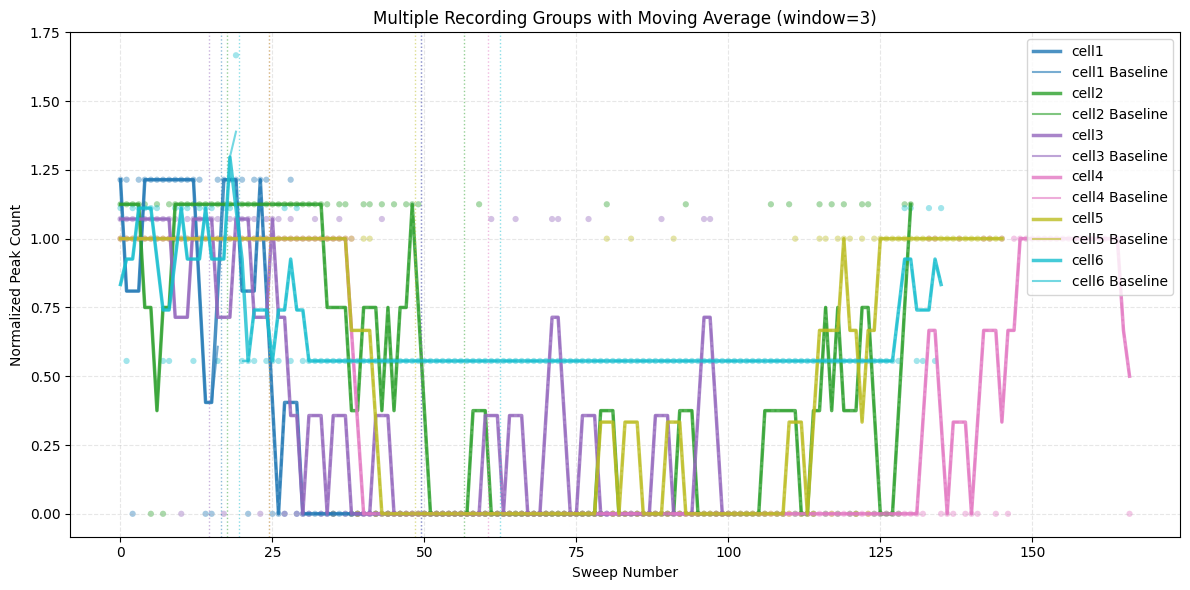

In [35]:
# Process all files
all_group_data = process_abf_files(file_groups)

# Plot with moving averages
fig = plot_multiple_groups(all_group_data, window_size=3, normalize=True)
plt.show()

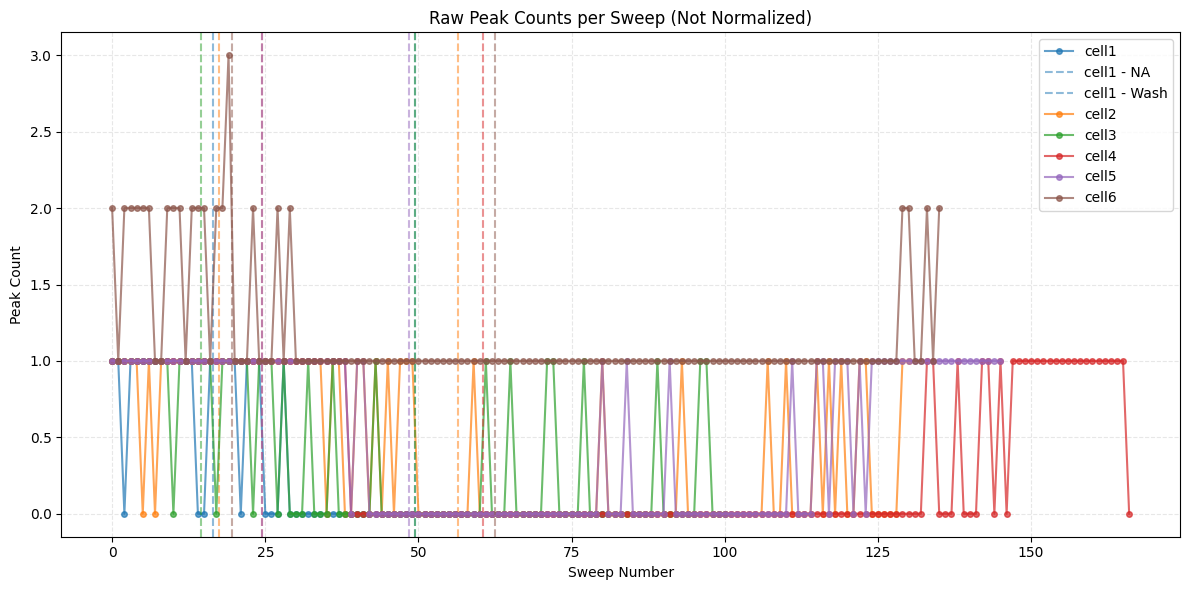

In [37]:

import numpy as np
import matplotlib.pyplot as plt
import pyabf
import os
from scipy.signal import find_peaks

def detect_peaks(data_array, height_threshold=0, prominence_min=0.1, distance_min=3):
    """Detects peaks in the signal"""
    peaks, _ = find_peaks(
        data_array,
        height=height_threshold,
        prominence=prominence_min,
        distance=distance_min
    )
    return len(peaks)  # Return just the count of peaks

def plot_raw_concatenated_data(file_groups):
    """
    Plot raw peak counts for concatenated files without normalization or smoothing
    
    Args:
        file_groups: Dictionary with group names as keys and lists of ABF file paths as values
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Set colors for different groups
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # For legend - condition names
    condition_names = ['Baseline', 'NA', 'Wash']
    
    for group_idx, (group_name, file_paths) in enumerate(file_groups.items()):
        color = colors[group_idx % len(colors)]
        
        # Lists to store data
        all_sweep_counts = []
        sweep_boundaries = [0]  # Start with 0
        total_sweeps = 0
        
        # Process each ABF file
        for file_idx, file_path in enumerate(file_paths):
            try:
                abf = pyabf.ABF(file_path)
                file_peak_counts = []
                
                # Process each sweep
                for sweep in abf.sweepList:
                    abf.setSweep(sweep)
                    peak_count = detect_peaks(abf.sweepY)
                    file_peak_counts.append(peak_count)
                
                # Add to our data collection
                all_sweep_counts.extend(file_peak_counts)
                total_sweeps += len(file_peak_counts)
                sweep_boundaries.append(total_sweeps)
                
            except Exception as e:
                print(f"Error processing {os.path.basename(file_path)}: {str(e)}")
        
        # Create x-axis values - continuous sweep numbers
        sweep_numbers = np.arange(len(all_sweep_counts))
        
        # Plot the raw peak counts
        ax.plot(sweep_numbers, all_sweep_counts, '-o', color=color, 
                label=group_name, alpha=0.7, markersize=4)
        
        # Add vertical lines at boundaries between conditions
        for i in range(1, len(sweep_boundaries)-1):
            boundary = sweep_boundaries[i]
            condition = condition_names[i] if i < len(condition_names) else f"Condition {i}"
            ax.axvline(x=boundary-0.5, color=color, linestyle='--', alpha=0.5,
                      label=f"{group_name} - {condition}" if group_idx == 0 else "")
    
    # Add labels and title
    ax.set_xlabel('Sweep Number')
    ax.set_ylabel('Peak Count')
    ax.set_title('Raw Peak Counts per Sweep (Not Normalized)')
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig

# Define data directory
base_dir = "/Volumes/joeschgrp/Group Members/Rima/Ephys_NE/DATA/ntsr1/"

# Define file groups - each group has baseline, NA, wash files
file_groups = {
      "cell1": [
          os.path.join(base_dir, "19.02.2025 M1/2025_02_19_0015.abf"),  # Baseline
          os.path.join(base_dir, "19.02.2025 M1/2025_02_19_0016.abf"),  # NA
          os.path.join(base_dir, "19.02.2025 M1/2025_02_19_0017.abf")   # Wash       
],
      "cell2": [
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0010.abf"),  # Baseline
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0011.abf"),  # NA
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0012.abf")   # Wash       
],
      "cell3": [
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0017.abf"),  # Baseline
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0018.abf"),  # NA
          os.path.join(base_dir, "20.02.2025 M3/2025_02_20_0019.abf")   # Wash       

],

      "cell4": [
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0001.abf"),  # Baseline
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0002.abf"),  # NA
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0003.abf")   # Wash       

],


      "cell5": [
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0011.abf"),  # Baseline
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0012.abf"),  # NA
          os.path.join(base_dir, "12.05.2025 M4/2025_05_12_0013.abf")   # Wash       

],


      "cell6": [
          os.path.join(base_dir, "13.05.2025 M6/2025_05_13_0002.abf"),  # Baseline
          os.path.join(base_dir, "13.05.2025 M6/2025_05_13_0003.abf"),  # NA
          os.path.join(base_dir, "13.05.2025 M6/2025_05_13_0004.abf")   # Wash       

],



}
# Create and show the plot
fig = plot_raw_concatenated_data(file_groups)
plt.show()

# Optionally save the figure
# fig.savefig('raw_peak_counts.png', dpi=300, bbox_inches='tight')